In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import category_encoders as ce

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import mannwhitneyu

import pingouin as pg

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve

C:\Users\johan\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
titanic = pd.read_csv('titanic_train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


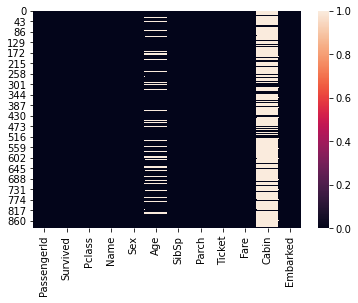

In [5]:
sns.heatmap(titanic.isna())
plt.show()

In [6]:
titanic.isna().sum()/len(titanic)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [7]:
titanic.columns = titanic.columns.str.lower()

In [9]:
titanic = titanic.drop(['cabin','passengerid','ticket'],axis=1)

> ## Data Cleaning

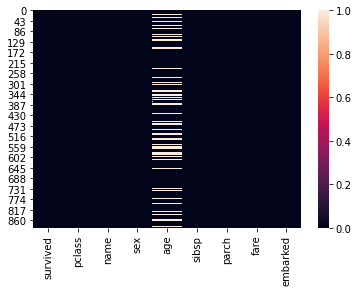

In [10]:
sns.heatmap(titanic.isna())
plt.show()

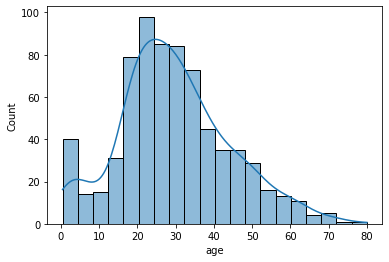

In [12]:
sns.histplot(titanic['age'],kde=True)
plt.show()

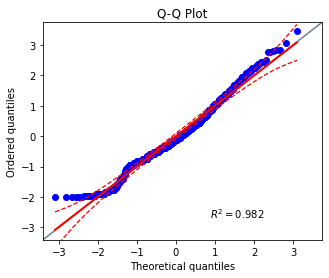

In [13]:
pg.qqplot(titanic['age'],dist='norm')
plt.show()

> ### Rapihin Embarked

In [14]:
titanic['embarked'].value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [15]:
titanic[titanic['embarked'].isna()==True]

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


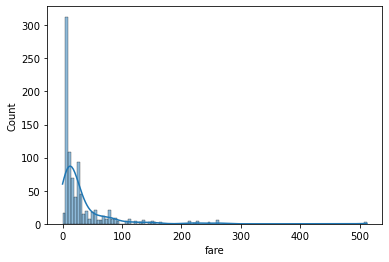

In [17]:
sns.histplot(titanic['fare'],kde=True)

## Karena skew, lebih baik pakai median aja agg func nya

In [18]:
pd.crosstab(index=titanic['embarked'],columns=titanic['pclass'],values=titanic['fare'],aggfunc=np.median)

pclass,1,2,3
embarked,,,
C,78.2667,24.00,7.8958
Q,90.0000,12.35,7.7500
S,52.0000,13.50,8.0500


In [19]:
pd.crosstab(index=titanic['embarked'],columns=titanic['sex'], normalize=1)

sex,female,male
embarked,,
C,0.233974,0.164645
Q,0.115385,0.071057
S,0.650641,0.764298


### Ceritanya cocokologinya, embarked lebih cocok ke S atau C. DIpilih S. Iyadeh

# Name

In [27]:
titanic['title']=titanic['name'].str.split(',').str[1].str.split('.').str[0]
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [30]:
titanic['title'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer'], dtype=object)

In [88]:
titanic=titanic.drop('name',axis=1)

In [89]:
titanic[titanic['title']==' Lady']

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
556,1,1,female,48.0,1,0,39.6,C,Lady


> ## EDA Lagi ?

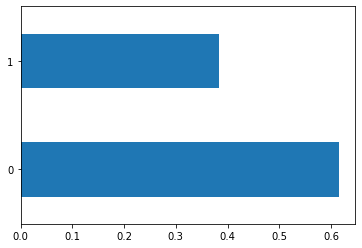

In [90]:
titanic.survived.value_counts(normalize=True).plot(kind='barh')
plt.show()

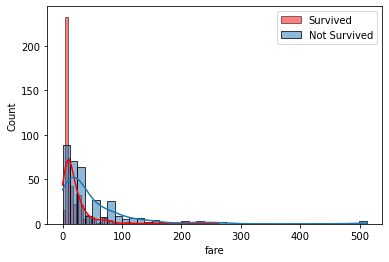

In [91]:
sns.histplot(titanic[titanic['survived']==0]['fare'],label='Survived',color='red',kde=True)
sns.histplot(titanic[titanic['survived']==1]['fare'],label='Not Survived',kde=True)
plt.legend()
plt.show()

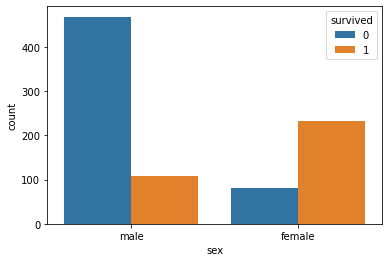

In [92]:
sns.countplot(x='sex', hue='survived',data=titanic)
plt.show()

In [93]:
pd.crosstab(index=titanic.sex,columns=titanic.survived,normalize=0)

survived,0,1
sex,,
female,0.257962,0.742038
male,0.811092,0.188908


C:\Users\johan\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 71.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 48.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


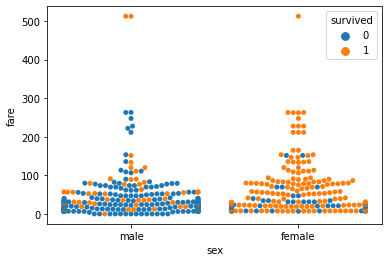

In [94]:
sns.swarmplot(y="fare", x="sex", hue="survived", data=titanic)
plt.show()

In [95]:
titanic['sibsp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

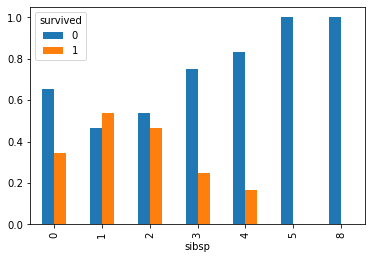

In [96]:
pd.crosstab(titanic.sibsp,titanic.survived,normalize=0).plot(kind='bar')
plt.show()

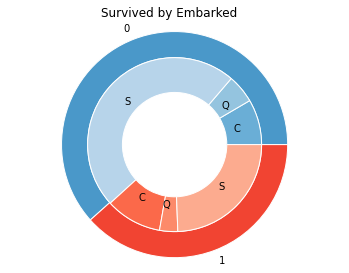

In [97]:
by_embarked = titanic.groupby('embarked')['survived'].value_counts().to_frame().rename(columns={'survived': 'freq'}).reset_index().sort_values('survived')

# Make data: I have 2 groups and 3 subgroups
group_names=titanic['survived'].value_counts().index
group_size=titanic['survived'].value_counts()
subgroup_names=by_embarked['embarked']
subgroup_size=by_embarked['freq']
 
# Create colors
a, b, c = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# First Ring (outside)
fig, ax = plt.subplots()
fig.suptitle('Survived by Embarked')
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), b(0.3)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

In [98]:
pd.crosstab(titanic.embarked,titanic.survived,normalize=1)

survived,0,1
embarked,,
C,0.136612,0.273529
Q,0.085610,0.088235
S,0.777778,0.638235


In [99]:
titanic[titanic['embarked']=='S']['pclass'].value_counts()

3    353
2    164
1    127
Name: pclass, dtype: int64

C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

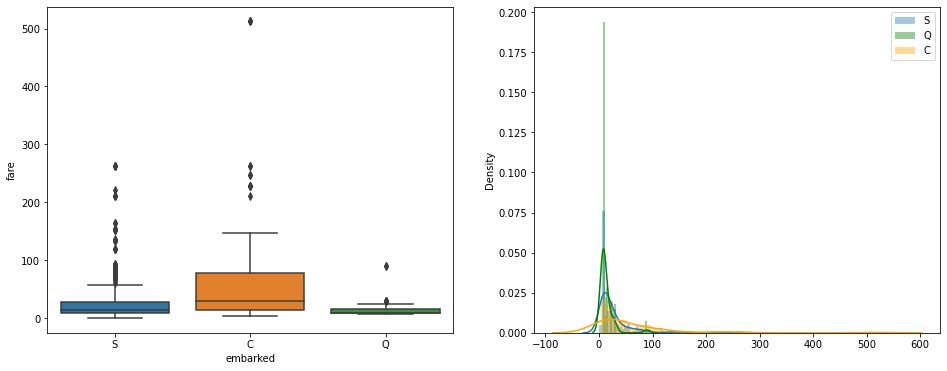

In [100]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.boxplot(x='embarked', y='fare',data=titanic)

plt.subplot(122)
sns.distplot(x=titanic[titanic['embarked']=='S']['fare'],label='S')
sns.distplot(x=titanic[titanic['embarked']=='Q']['fare'],label='Q',color='green')
sns.distplot(x=titanic[titanic['embarked']=='C']['fare'],label='C',color='orange')

plt.legend()
plt.show()

In [101]:
stats, p = mannwhitneyu(titanic[titanic['embarked']=='S']['fare'],titanic[titanic['embarked']=='C']['fare'],alternative='less')

if p<0.05:
    print('Southampton median fare are less than Cherbourg')
else:
    print('Southampton median fare are equal to Cherbourg')

Southampton median fare are less than Cherbourg


In [102]:
stats, p = mannwhitneyu(titanic[titanic['embarked']=='S']['fare'],titanic[titanic['embarked']=='Q']['fare'],alternative='less')

if p<0.05:
    print('Southampton median fare are less than Queenstown')
else:
    print('Southampton median fare are equal to Queenstown')

Southampton median fare are equal to Queenstown


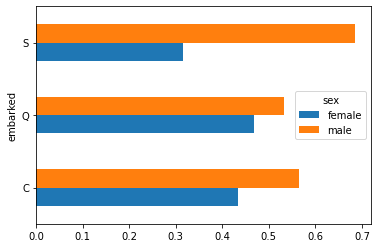

In [103]:
pd.crosstab(titanic.embarked,titanic.sex,normalize=0).plot(kind='barh')

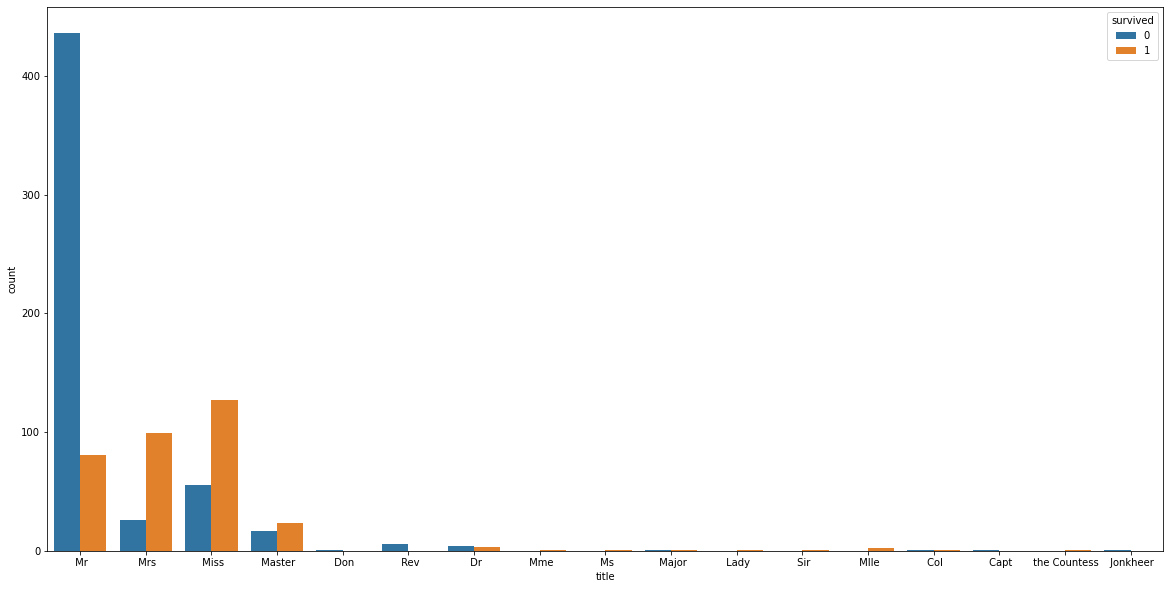

In [104]:
plt.figure(figsize=(20,10))
sns.countplot(x='title',hue='survived',data=titanic)
plt.show()

In [105]:
pd.crosstab(titanic.title,titanic.survived,normalize=0).sort_values(1,ascending=False)

survived,0,1
title,,
the Countess,0.000000,1.000000
Mlle,0.000000,1.000000
Sir,0.000000,1.000000
Ms,0.000000,1.000000
Lady,0.000000,1.000000
Mme,0.000000,1.000000
Mrs,0.208000,0.792000
Miss,0.302198,0.697802
Master,0.425000,0.575000


> ## Modeling

In [106]:
titanic.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
title         0
dtype: int64

### Skenario

1. Imputation

    Age impute with mean
    
    Embarked impute with S
    
1. Encoder

    Sex --> One Hot
    
    Embarked --> One Hot
    
    Title --> Binary
    
1. Drop

    PassengerId

## Data splitting

In [130]:
X = titanic.drop('survived',axis=1)
y = titanic['survived']

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.2, stratify=y,random_state=1912)

## Pipeline

In [131]:
# untuk impute age
num_pipeline = Pipeline([
    ('impute_num',SimpleImputer(strategy='mean'))
])

# untuk impute embarked and onehot
onehot_pipeline = Pipeline([
    ('impute_cat',SimpleImputer(strategy='constant',fill_value='S')),
    ('onehot',OneHotEncoder(drop='first'))
])

#binary title
binary_pipeline = Pipeline([
    ('binary',ce.BinaryEncoder())
])

# untuk onehot_pipe, karena sex tidak ada yang kosong, maka gabakal di isi S
transformer = ColumnTransformer([
    ('imputenum_pipe',num_pipeline,['age']),
    ('onehot_pipe',onehot_pipeline,['sex','embarked']),
    ('binary_pipe',binary_pipeline,['title']),
],remainder='passthrough')

dtc = DecisionTreeClassifier(max_depth=5, random_state=1912)
smote = SMOTE(random_state=1912)
rfe = RFE(dtc)

all_in_pipeline=Pipeline([
    ('transformer',transformer),
    ('rfe',rfe),
    ('resampling',smote),
    ('clf',dtc)
])

In [132]:
all_in_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('imputenum_pipe',
                                    Pipeline(steps=[('impute_num',
                                                     SimpleImputer())]),
                                    ['age']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('impute_cat',
                                                     SimpleImputer(fill_value='S',
                                                                   strategy='constant')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['sex', 'embarked']),
                                   ('binary_pipe',
                                    Pipeline(steps=[('binary', BinaryEncoder())]),
                                    ['t

In [133]:
hyperparam_space = {
    'clf__max_depth': [2,3,4,5,6,7],
    'clf__min_samples_split': [4,5,6,7,8,9,10],
    'clf__criterion': ['entropy', 'gini'],
    'rfe__n_features_to_select': [None,5,6,7,8]
}

skf=StratifiedKFold(n_splits=5)

gridsearch = GridSearchCV(all_in_pipeline,hyperparam_space,cv=skf,scoring='f1',n_jobs=-1,verbose=1)

gridsearch.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1996 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 2077 out of 2100 | elapsed:   23.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:   23.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputenum_pipe',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer())]),
                                                                         ['age']),
                                                                        ('onehot_pipe',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(fill_value='S',
                                                                                   

In [134]:
cv_res_df = pd.DataFrame(gridsearch.cv_results_)
cv_res_df[cv_res_df['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
70,0.092192,0.008061,0.020509,0.001743,entropy,4,4,None,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1
72,0.089563,0.009440,0.019382,0.003444,entropy,4,4,6,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1
73,0.078969,0.001879,0.017990,0.001678,entropy,4,4,7,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1
74,0.073601,0.004982,0.027590,0.002847,entropy,4,4,8,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1
75,0.084135,0.009062,0.024005,0.001969,entropy,4,5,None,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1
77,0.084572,0.009461,0.020597,0.002559,entropy,4,5,6,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1
78,0.082769,0.009821,0.026074,0.005652,entropy,4,5,7,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1
79,0.075737,0.004944,0.022167,0.005433,entropy,4,5,8,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1
80,0.082080,0.006862,0.020346,0.001954,entropy,4,6,None,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1
82,0.089157,0.004577,0.018751,0.001323,entropy,4,6,6,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.705882,0.72381,0.807339,0.776699,0.77551,0.757848,0.037352,1


In [135]:
print('best score',gridsearch.best_score_)
print('best parameter',gridsearch.best_params_)

best score 0.7578481118999663
best parameter {'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__min_samples_split': 4, 'rfe__n_features_to_select': None}


## COMPARE : DEFAULT MODEL & TUNED MODEL

In [146]:
model_tuned = gridsearch.best_estimator_.fit(X_train_val, y_train_val)
y_pred_tuned = estimator_tuned.predict(X_test)

print('TUNED :')
print(classification_report(y_test, y_pred_tuned))

TUNED :
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       110
           1       0.77      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



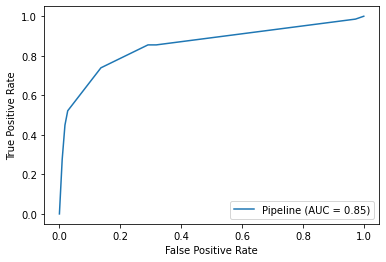

In [147]:
plot_roc_curve(model_tuned, X_test, y_test)

In [143]:
model_default = all_in_pipeline.fit(X_train_val, y_train_val)
y_pred_default = model_default.predict(X_test)
print('DEFAULT :')
print(classification_report(y_test,y_pred_default))

DEFAULT :
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       110
           1       0.77      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



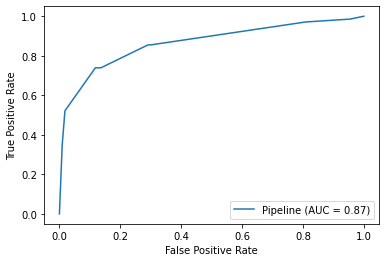

In [144]:
plot_roc_curve(model_default, X_test, y_test)

In [148]:
prob1 = model_default.predict_proba(X_test)[:,1]
fpr, tpr, thr = roc_curve(y_test, prob1)
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thr': thr})
roc_df

,fpr,tpr,thr
0,0.000000,0.000000,2.000000
1,0.009091,0.347826,1.000000
2,0.018182,0.521739,0.951456
3,0.118182,0.739130,0.680000
4,0.136364,0.739130,0.666667
5,0.290909,0.855072,0.376147
6,0.300000,0.855072,0.166667
7,0.809091,0.971014,0.125000
8,0.954545,0.985507,0.050000
9,1.000000,1.000000,0.000000


              precision    recall  f1-score   support

           0       0.89      0.70      0.78       110
           1       0.64      0.86      0.73        69

    accuracy                           0.76       179
   macro avg       0.76      0.78      0.76       179
weighted avg       0.79      0.76      0.76       179



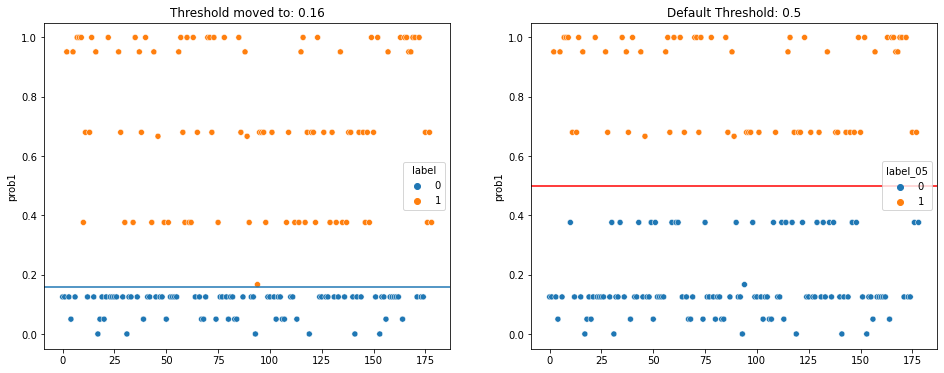

In [153]:
thr_move_to = 0.16
y_pred_thr = np.where(model_default.predict_proba(X_test)[:,1] > thr_move_to, 1, 0)
print(classification_report(y_test, y_pred_thr))

thr_test_df = pd.DataFrame(dict(zip(['label', 'prob1', 'label_05'], [y_pred_thr, model_default.predict_proba(X_test)[:,1], model_default.predict(X_test)])))
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title(f'Threshold moved to: {thr_move_to}')
sns.scatterplot(x=thr_test_df.index, y=thr_test_df['prob1'], hue=thr_test_df['label'])
plt.axhline(thr_move_to)

plt.subplot(122)
plt.title('Default Threshold: 0.5')
sns.scatterplot(x=thr_test_df.index, y=thr_test_df['prob1'], hue=thr_test_df['label_05'])
plt.axhline(0.5, color='red')

plt.show()

In [154]:
thr_test_df

,label,prob1,label_05
0,0,0.125000,0
1,0,0.125000,0
2,1,0.951456,1
3,0,0.125000,0
4,0,0.050000,0
...,...,...,...
174,0,0.125000,0
175,1,0.680000,1
176,1,0.376147,0
177,1,0.680000,1


In [150]:
titanic[titanic['pclass'] == 1]['fare'].mean()

84.15468749999992

In [155]:
X.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'title'], dtype='object')

In [151]:
rose = [[1, 'female', 17, 1, 1, 85, 'S', 'Miss']]
model_default.predict(pd.DataFrame(rose, columns=X_train_val.columns))

array([1], dtype=int64)

In [152]:
jack = [[3, 'male', 20, 0, 0, 0, 'S', 'Mr']]
model_default.predict(pd.DataFrame(jack, columns=X_train_val.columns))

array([0], dtype=int64)